<a href="https://colab.research.google.com/github/cat-oss/lecture0/blob/master/DL_Project_Fruit_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 8693, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8672/8672), done.
remote: Total 385858 (delta 36), reused 8670 (delta 21), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 39.89 MiB/s, done.
Resolving deltas: 100% (1196/1196), done.
Checking out files: 100% (90503/90503), done.


In [2]:
pip install torch-lr-finder

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder

# from tqdm.notebook import tqdm

In [4]:
device = torch.device('cpu') # 'cpu' can be changed to 'cuda' to run the operations on the GPU
if torch.cuda.is_available():
    device = torch.device('cuda')

In [5]:
device

device(type='cuda')

In [6]:
!nvidia-smi

Thu Jan 28 15:46:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
##############################################
learning_rate = 0.1  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
 
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = './Fruit-Images-Dataset'  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = 'output_files'  # root folder in which to save the the output files; the files will be under output_files/model_name 
##############################################

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)

In [9]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Labels and quantity of labels
print(labels)
print(num_classes)

['Onion White', 'Pepper Green', 'Cantaloupe 2', 'Plum', 'Apricot', 'Pear', 'Plum 3', 'Physalis with Husk', 'Apple Crimson Snow', 'Onion Red Peeled', 'Cherry 1', 'Cucumber Ripe', 'Apple Red Delicious', 'Pineapple Mini', 'Cauliflower', 'Pomelo Sweetie', 'Lemon Meyer', 'Grape White 3', 'Melon Piel de Sapo', 'Pomegranate', 'Guava', 'Potato Red Washed', 'Limes', 'Strawberry Wedge', 'Peach', 'Lemon', 'Pear Red', 'Apple Red Yellow 2', 'Dates', 'Plum 2', 'Onion Red', 'Tomato 3', 'Nectarine', 'Potato Sweet', 'Nut Pecan', 'Tomato 2', 'Cantaloupe 1', 'Kumquats', 'Apple Red 2', 'Lychee', 'Pepper Orange', 'Avocado', 'Tomato Heart', 'Grape Blue', 'Huckleberry', 'Cherry 2', 'Pineapple', 'Cherry Wax Yellow', 'Pear Stone', 'Fig', 'Potato White', 'Ginger Root', 'Banana Lady Finger', 'Apple Golden 1', 'Cucumber Ripe 2', 'Pear Williams', 'Cherry Wax Black', 'Apple Red 3', 'Peach Flat', 'Beetroot', 'Apple Golden 3', 'Maracuja', 'Tangelo', 'Apple Granny Smith', 'Chestnut', 'Kaki', 'Passion Fruit', 'Blueberr

In [11]:
train_set = datasets.ImageFolder(train_dir, transform = transformations)
val_set = datasets.ImageFolder(test_dir, transform = transformations)

In [13]:
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =50, shuffle=True)

# Convolutional neural network

In [14]:
class ConvNet(nn.Module):
    def __init__(self, n_classes=131, p = 0.2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, padding = 2, kernel_size = (5,5))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, padding = 2, kernel_size = (5,5))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, padding = 2, kernel_size = (5,5))
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, padding = 2, kernel_size = (5,5))
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(6 * 6 * 128, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 131)
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # x = nn.Softmax(dim = 1)(x)
        return x

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-02


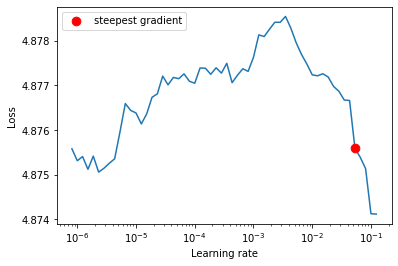

In [34]:
from tqdm.auto import tqdm
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-1)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [35]:
from tqdm.auto import tqdm
model = ConvNet().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#We train the model for 25 epochs
num_epochs = 25 #change if it takes to much time to run

for epoch in range(num_epochs):
    print('EPOCH {}'.format(epoch))
    running_loss = 0.0
    correct = 0
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        # correct += (y_hat == y).float().sum()
    print('Loss: {:.3f}'.format(running_loss))


EPOCH 0



Loss: 2117.876
EPOCH 1



Loss: 409.471
EPOCH 2



Loss: 235.999
EPOCH 3



Loss: 180.069
EPOCH 4



Loss: 160.553
EPOCH 5



Loss: 116.868
EPOCH 6



Loss: 127.757
EPOCH 7



Loss: 101.036
EPOCH 8



Loss: 108.191
EPOCH 9



Loss: 89.529
EPOCH 10



Loss: 85.132
EPOCH 11



Loss: 99.793
EPOCH 12



Loss: 89.846
EPOCH 13



Loss: 76.244
EPOCH 14



Loss: 76.958
EPOCH 15



Loss: 68.584
EPOCH 16



Loss: 83.904
EPOCH 17



Loss: 67.186
EPOCH 18



Loss: 63.025
EPOCH 19



Loss: 79.574
EPOCH 20



Loss: 67.670
EPOCH 21



Loss: 65.946
EPOCH 22



Loss: 70.066
EPOCH 23



Loss: 75.037
EPOCH 24



Loss: 58.192


In [36]:
 true_labels = []
predicted_labels = []

for x, y in val_loader: # we iterate over the test dataset
    true_labels.append(y.numpy())
    x, y = x.to(device), y.to(device)
    y_hat = model(x) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
    y_hat = nn.Softmax(dim=0)(y_hat) # these are the estimated probability of belonging to each class
    y_hat = y_hat.argmax(dim=1) # these are the most likely classes
    predicted_labels.append(y_hat.detach().cpu().numpy())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

In [37]:
print('The accuracy is {:.1f}%'.format(100 * (true_labels == predicted_labels).mean()))

The accuracy is 73.5%
